In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
%cd drive/MyDrive/engg680_2024_fall/Lab_Assignment3/

/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3


# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | First Name | Last Name | Signature | Hours | Contribution |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

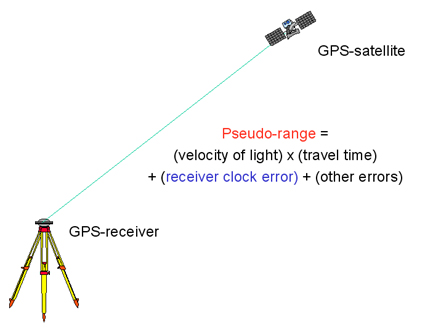

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [ ]:
df_pseudorange = pd.read_excel('pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
     # Calculate the predicted pseudorange based on the receiver's position and clock offset
    predicted_pseudorange = euclidean_norm(r_pos, s_pos) - cdT

    # Compute residuals (difference between observed and predicted pseudoranges)
    residuals = pseudorange - predicted_pseudorange

    # Sum of squared residuals
    L = np.sum(residuals ** 2)
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    # Calculate geometric range between receiver and satellite positions
    predicted_pseudorange = euclidean_norm(r_pos, s_pos) - cdT

    # Calculate residuals
    residuals = pseudorange - predicted_pseudorange

    # Calculate partial derivatives with respect to each parameter
    d_rho_dx = (r_pos[0] - s_pos[:, 0]) / predicted_pseudorange
    d_rho_dy = (r_pos[1] - s_pos[:, 1]) / predicted_pseudorange
    d_rho_dz = (r_pos[2] - s_pos[:, 2]) / predicted_pseudorange
    d_rho_dcdT = -1  # derivative with respect to cdT is simply -1 for each residual

    # Compute gradients as the sum of residuals * partial derivatives
    grad_x = -2 * np.sum(residuals * d_rho_dx)
    grad_y = -2 * np.sum(residuals * d_rho_dy)
    grad_z = -2 * np.sum(residuals * d_rho_dz)
    grad_cdT = -2 * np.sum(residuals * d_rho_dcdT)

    # Return gradient as a numpy array
    grad = np.array([grad_x, grad_y, grad_z, grad_cdT])
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0.0,0.0,0.0,0.0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# print the mentioned metrics
print("Optimized Parameters (x, y, z, cdT):", optimized_params)
print("Final Position Errors of Receiver:", optimized_params[:3] - GroundTruth)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", arr_cost[-1])
print("Final Gradient Values:", arr_grad[-1])

Converged !
Optimized Parameters (x, y, z, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06 -6.46515752e+00]
Final Position Errors of Receiver: [-3.0641334  -2.3559408   3.80106529]
Number of Steps Taken for Convergence: 2852
Final Cost Value: 6.197096039862895
Final Gradient Values: [ 0.00049637  0.00276577 -0.00850034  0.00481904]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

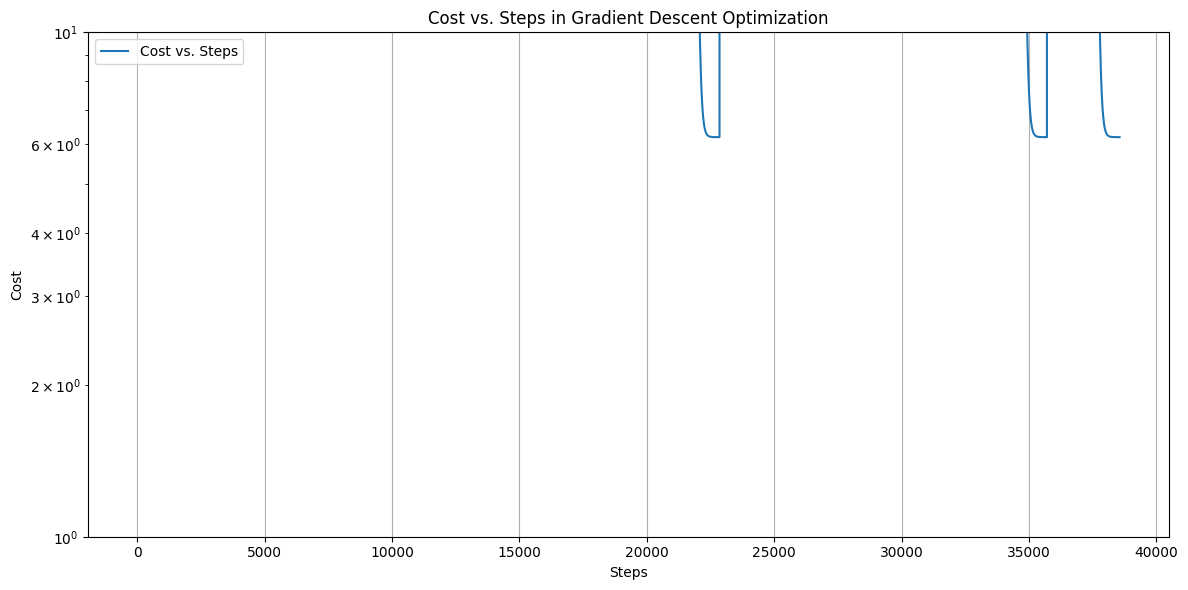

As the steps increase, the cost decreases, showing convergence over time.  


In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(12,6))
# Plot cost vs. steps with a semilogarithmic scale on the y-axis
ax.semilogy(arr_cost, label='Cost vs. Steps')
ax.set_xlabel('Steps')
ax.set_ylabel('Cost')
ax.set_title('Cost vs. Steps in Gradient Descent Optimization')
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

# Comment on the pattern
print("As the steps increase, the cost decreases, showing convergence over time.  ")

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# ...
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# ...

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
# ...
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# ...

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = #...

# print the metrics
# ...

In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = #...

# print the metrics
# ...

## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [5]:
!pip install ucimlrepo

In [11]:
from ucimlrepo import fetch_ucirepo
# Load the ARFF file
data, meta = arff.loadarff('Training Dataset.arff')
df = pd.DataFrame(data)
# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
df = pd.DataFrame(data)
# TO DO: display sizes of X and y (1 mark)
print("Size of X:", X.shape)
print("Size of y:", y.shape)

Size of X: (11055, 30)
Size of y: (11055,)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

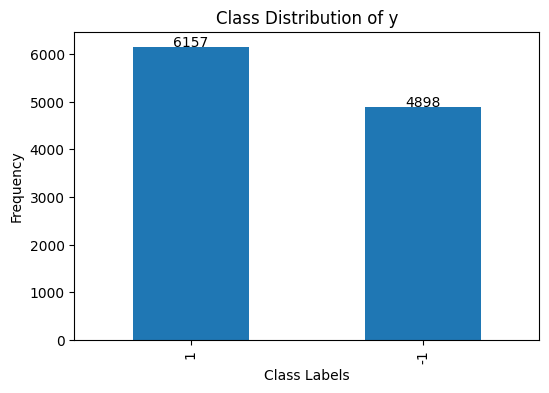

In [12]:
# TO DO: Check the class distribution of y (2 mark)
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
y.value_counts().plot(kind='bar')
plt.title('Class Distribution of y')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
# Display exact values for each bin in the histogram
for index, value in enumerate(y.value_counts()):
    plt.text(index, value + 5, str(value), ha='center')
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [13]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)
# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)

Size of X_small: (331, 30)
Size of y_small: (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [16]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model with max_iter=2000
model = LogisticRegression(max_iter=2000)

# 1. Train the model using the entire dataset X and y
model.fit(X, y)
print("Model trained on full dataset (X, y)")

# 2. Train the model using only the first two columns of X and y
X_two_columns = X.iloc[:, :2]  # Select only the first two columns of X
model.fit(X_two_columns, y)
print("Model trained on first two columns of X and y")

# 3. Train the model using the smaller dataset X_small and y_small
model.fit(X_small, y_small)
print("Model trained on smaller dataset (X_small, y_small)")

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

# Function to evaluate the model on a given dataset
def evaluate_model(X_data, y_data, description):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

    # Train the model on the training set
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)  # Needed for log loss

    # Calculate metrics
    data_size = X_data.shape[0]
    num_train_samples = X_train.shape[0]
    num_test_samples = X_test.shape[0]
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    log_loss_value = log_loss(y_test, y_test_prob)

    # Display results
    print(f"\nEvaluation for {description}:")
    print(f"Data size: {data_size}")
    print(f"Number of training samples: {num_train_samples}")
    print(f"Number of testing samples: {num_test_samples}")
    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Testing accuracy: {test_accuracy:.4f}")
    print(f"Log loss: {log_loss_value:.4f}")

# Evaluate model on each dataset

# 1. Full dataset (X, y)
evaluate_model(X, y, "Full dataset (X, y)")

# 2. First two columns of X and y
evaluate_model(X.iloc[:, :2], y, "First two columns of X")

# 3. Smaller dataset (X_small, y_small)
evaluate_model(X_small, y_small, "Smaller dataset (X_small, y_small)")
# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

import pandas as pd

# Modified evaluate_model function to return metrics as a dictionary
def evaluate_model(X_data, y_data, description):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)

    # Train the model on the training set
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)  # Needed for log loss

    # Calculate metrics
    data_size = X_data.shape[0]
    num_train_samples = X_train.shape[0]
    num_test_samples = X_test.shape[0]
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    log_loss_value = log_loss(y_test, y_test_prob)

    # Return results as a dictionary
    return {
        "Description": description,
        "Data Size": data_size,
        "Training Samples": num_train_samples,
        "Testing Samples": num_test_samples,
        "Training Accuracy": train_accuracy,
        "Testing Accuracy": test_accuracy,
        "Log Loss": log_loss_value
    }

# List to store the results
results_list = []

# Evaluate each dataset and store results
results_list.append(evaluate_model(X, y, "Full dataset (X, y)"))
results_list.append(evaluate_model(X.iloc[:, :2], y, "First two columns of X"))
results_list.append(evaluate_model(X_small, y_small, "Smaller dataset (X_small, y_small)"))

# Create a DataFrame from the results
results = pd.DataFrame(results_list)

# Print the results DataFrame
print(results)

Model trained on full dataset (X, y)
Model trained on first two columns of X and y
Model trained on smaller dataset (X_small, y_small)

Evaluation for Full dataset (X, y):
Data size: 11055
Number of training samples: 7738
Number of testing samples: 3317
Training accuracy: 0.9311
Testing accuracy: 0.9219
Log loss: 0.1879

Evaluation for First two columns of X:
Data size: 11055
Number of training samples: 7738
Number of testing samples: 3317
Training accuracy: 0.5540
Testing accuracy: 0.5773
Log loss: 0.6774

Evaluation for Smaller dataset (X_small, y_small):
Data size: 331
Number of training samples: 231
Number of testing samples: 100
Training accuracy: 0.9481
Testing accuracy: 0.9300
Log loss: 0.1923
                          Description  Data Size  Training Samples  \
0                 Full dataset (X, y)      11055              7738   
1              First two columns of X      11055              7738   
2  Smaller dataset (X_small, y_small)        331               231   

   Testin

### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [17]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
from sklearn.model_selection import train_test_split

# Split the full dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Print the dimensions of the predicted output
print("Shape of predicted output:", y_pred.shape)


Shape of predicted output: (3317,)


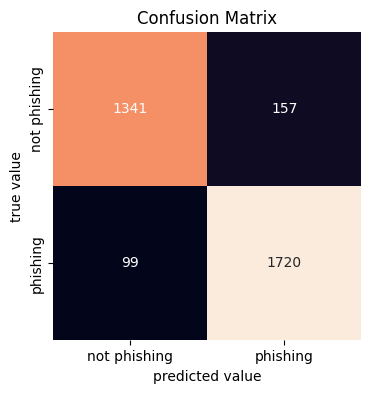

In [18]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
conf_mat = confusion_matrix(y_test, y_pred)
# Below code prints confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['not phishing', 'phishing']))


Classification Report:
              precision    recall  f1-score   support

not phishing       0.93      0.90      0.91      1498
    phishing       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

1. Yes, the dataset is imbalanced, as shown in Step 2.1’s class label histogram. There are more samples in one class than in the other, which can affect model performance. In an imbalanced dataset, the model may be biased towards predicting the majority class more often, leading to poor detection of the minority class. This can cause higher false negative rates if the minority class is underrepresented, making the model less effective at identifying phishing websites.

2. For the full dataset (X, y), the model likely performs best, with less risk of overfitting or underfitting since it has access to all available features and data points. However, it could still overfit if the model complexity is too high. Using only two columns significantly reduces the model's ability to capture the complexity of the data, which can lead to underfitting, as the model may not have enough information to generalize well to new data. Testing accuracy is likely lower than training accuracy in this case, suggesting underfitting. Since the smaller dataset has fewer data points, it risks overfitting, especially if the model memorizes the smaller dataset rather than generalizing well. The testing accuracy might be significantly lower than the training accuracy here, suggesting overfitting.

3. Generally, using more data (as in the full dataset) improves both training and testing accuracy. For the full dataset, training and testing accuracies are closer, indicating a good balance between fitting and generalization. For the smaller dataset, training accuracy may be higher than testing accuracy, suggesting overfitting. With the reduced feature set (first two columns), both training and testing accuracies are lower, indicating that the model lacks sufficient information to learn effectively. Exact values would depend on the results obtained in Step 4, but the trend would likely follow this pattern.

4. In this case, a false positive represents predicting a legitimate website as phishing. This could inconvenience users by blocking access to safe sites or marking them as suspicious. A false negative represents predicting a phishing website as legitimate. This is more dangerous because it exposes users to potential phishing attacks, leading to data theft or other security risks. In this context, false negatives are worse because they fail to protect users from phishing websites, which is the primary goal of the model.

5. Based on the answer to question 4, it is better to maximize recall, especially for the phishing (positive) class. Maximizing recall reduces the chance of false negatives, which means fewer phishing sites are incorrectly classified as legitimate. To increase recall, the classification threshold could be adjusted to be more sensitive to the phishing class. Additionally, class weighting or sampling techniques could be used to give more importance to the phishing class in the training process.

6. For the full dataset (X, y), the Log Loss should be lowest, as the model has access to all features and a larger dataset, allowing it to make better-calibrated probability estimates. The Log Loss is likely higher when using only the first two columns because the model has limited information with only two features, preventing it from making confident predictions, leading to poorly calibrated probabilities. In the case of the smaller dataset, the Log Loss may also be higher due to the limited number of samples, which can cause the model to overfit and produce less accurate probability estimates for unseen data. The differences in Log Loss arise from the amount and quality of information available. The full dataset provides the most information, while the other two cases restrict the model’s ability to generalize well.